In [1]:
import pandas as pd #load and manipulate data and for one-hot encoding

import numpy as np # calculate the mean and standard deviation

import xgboost as xgb

from sklearn.model_selection import train_test_split # split training/testing set
from sklearn.model_selection import GridSearchCV #cross validation
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix # create a confusion matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt



In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [3]:
print('general info:')
train.info()

print("Unique values by column:")
cols = [
    'Time_spent_Alone',
    'Stage_fear',
    'Social_event_attendance',
    'Going_outside',
    'Drained_after_socializing',
    'Friends_circle_size',
    'Post_frequency',
    'Personality'
]

for col in cols:
    print(f"\n{col}:")
    print(train[col].unique())

print('missing data:')
missing = train.isnull().sum()
print(missing)


general info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
Unique values by column:

Time_spent_Alone:
[ 0.  1.  6.  3.  2.  4. nan  5.  9. 10.  7.  8. 11.]

Stage_fear:
['No' 'Yes' nan]

Social_event_attendance:
[ 6.  7.  1.  4.  8.  2.  5. nan  0.  9.  3. 1

In [4]:
train['Personality'].value_counts(normalize=True)

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64

In [5]:
label_cols = ['Stage_fear', 'Drained_after_socializing', 'Personality']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    if col in test.columns:
        test[col] = le.transform(test[col].astype(str))
    le_dict[col] = le

print(train)
print(test)

          id  Time_spent_Alone  Stage_fear  Social_event_attendance  \
0          0               0.0           0                      6.0   
1          1               1.0           0                      7.0   
2          2               6.0           1                      1.0   
3          3               3.0           0                      7.0   
4          4               1.0           0                      4.0   
...      ...               ...         ...                      ...   
18519  18519               3.0           0                      7.0   
18520  18520               1.0           2                      6.0   
18521  18521               7.0           1                      1.0   
18522  18522               NaN           1                      1.0   
18523  18523               1.0           0                      8.0   

       Going_outside  Drained_after_socializing  Friends_circle_size  \
0                4.0                          0                 15.0   
1  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



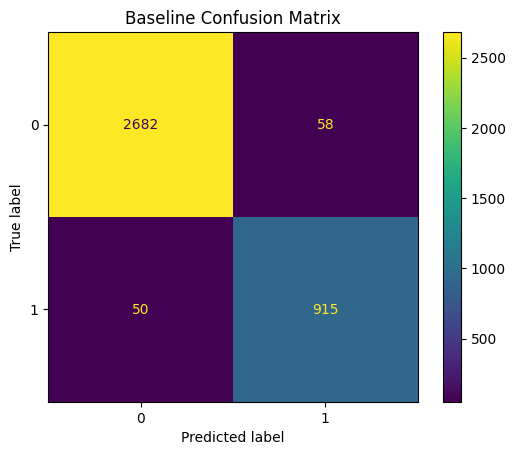

In [6]:
# Define features and target
X = train.drop(columns=['id', 'Personality'])
y = train['Personality']

# Let's first look at the baseline XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

baseline_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
baseline_model.fit(X_train, y_train)

# Evaluate baseline model
y_pred_baseline = baseline_model.predict(X_test)
print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test)
plt.title("Baseline Confusion Matrix")
plt.show()

In [7]:
#scale_pos_weight = (number of negative class samples) / (number of positive class samples)
#scale_pos_weight = 2740 / 965 ≈ 2.84


In [8]:
# 4. Hyperparameter Tuning with Cross-Validation
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2.5, 3]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 2.5, 3],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

Tuned Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2740
           1       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



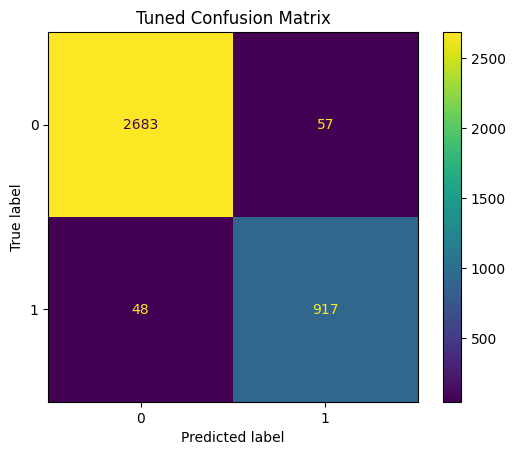

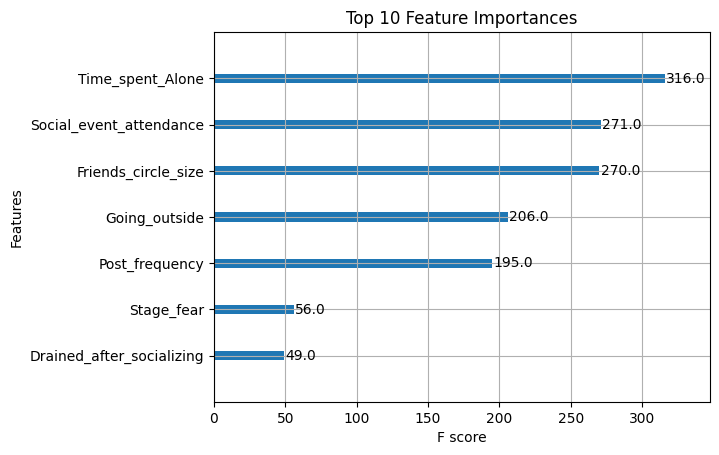

In [9]:
# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Tuned Model Performance:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Tuned Confusion Matrix")
plt.show()

# Feature importance
xgb.plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

In [10]:
X_test_t = test.drop(columns=['id'])
y_test_pred = best_model.predict(X_test_t)
y_test_pred_labels = le.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    'id': test['id'],
    'Personality': y_test_pred_labels
})

submission.to_csv("Predict the Introverts from the Extroverts.csv", index=False)


In [11]:
submission.shape


(6175, 2)

In [12]:
# inbalanced data
# xgboost
# crass validation(AUC to evaluate the performace), balance the postive and negitive weithg via scale_pos_weight